- Keys in file: ['Day_1', 'Meta']
- Keys inside Meta: ['Age', 'Code', 'Height', 'No. Days', 'Sex', 'Weight']
- Keys inside Day_1: ['MVC', 'Trial_01', 'Trial_02', 'Trial_03', 'Trial_04', 'Trial_05', 'Trial_06', 'Trial_07', 'Trial_08', 'Trial_09', 'Trial_10', 'Trial_11', 'Trial_12', 'Trial_13', 'Trial_14', 'Trial_15', 'Trial_16', 'Trial_17', 'Trial_18', 'Trial_19', 'Trial_20', 'Trial_21', 'Trial_22', 'Trial_23', 'Trial_24', 'Trial_25', 'Trial_26', 'Trial_27', 'Trial_28', 'Trial_29', 'Trial_30', 'Trial_31', 'Trial_32', 'Trial_33', 'Trial_34', 'Trial_35', 'Trial_36']
- Keys inside Trial_01 : ['Acc_Left_Foot', 'Acc_Left_Shank', 'Acc_Left_Thigh', 'Acc_Pelvis', 'Acc_Right_Foot', 'Acc_Right_Shank', 'Acc_Right_Thigh', 'Acc_T8', 'Ang_L5S1', 'Ang_Left_Ankle', 'Ang_Left_Hip', 'Ang_Left_Knee', 'Ang_Right_Ankle', 'Ang_Right_Hip', 'Ang_Right_Knee', 'EMG_Left_BF', 'EMG_Left_GM', 'EMG_Left_Gmax', 'EMG_Left_Gmed', 'EMG_Left_RF', 'EMG_Left_ST', 'EMG_Left_TA', 'EMG_Left_VL', 'EMG_Right_BF', 'EMG_Right_GM', 'EMG_Right_Gmax', 'EMG_Right_Gmed', 'EMG_Right_RF', 'EMG_Right_ST', 'EMG_Right_TA', 'EMG_Right_VL', 'Gyr_Left_Foot', 'Gyr_Left_Shank', 'Gyr_Left_Thigh', 'Gyr_Pelvis', 'Gyr_Right_Foot', 'Gyr_Right_Shank', 'Gyr_Right_Thigh', 'Gyr_T8', 'Label', 'Markers', 'Time']

=> here, we extract only the EMG contents: ones that start with "EMG_ ..."


In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../Shared')
import processing, Model, Visualization


def label_extraction(data):
    # --- (1) Label 추출 ---
    y = data["Label"][:].astype(float).ravel()
    valid_idx = np.where((y != -2) & (y != -1))[0] # 불필요한 레이블(-2, -1) 제거
    y = y[valid_idx]
    return y, valid_idx

def stack_signals(trial, keys, valid_idx):
    # --- (2) Modality 별 데이터 추출 ---
    """여러 channel(dataset)을 axis=1 로 합치기"""
    data_list = []
    for k in keys:
        d = trial[k][:]
        if d.ndim == 1:
            d = d[:, np.newaxis]  # (samples,) -> (samples, 1)
        data_list.append(d)
    data = np.hstack(data_list)   # (samples, channels)
    return data[valid_idx]


def Downsample_to_balance_class(y, ):
    # --- (3) Downsampling to balance classes ---
    df = pd.DataFrame({"y": y})

    balanced_idx = []
    for lbl in np.unique(y):
        lbl_idx = np.where(y == lbl)[0]
        min_n = df["y"].value_counts().min()  # 가장 작은 클래스 크기
        sampled_idx = resample(lbl_idx, n_samples=min_n, random_state=42, replace=False)
        balanced_idx.extend(sampled_idx)

    balanced_idx = np.array(balanced_idx)
    return balanced_idx

def random_downsample(X, y=None, fraction=0.5, random_state=42):
    # --- (4) when the data is too much, we randomly remove samples by fraction % ---
    #fraction: 남길 비율

    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_keep = int(n_samples * fraction)
    idx_keep = np.random.choice(n_samples, size=n_keep, replace=False)

    X_down = X[idx_keep]

    if y is not None:
        y_down = y[idx_keep]
        return X_down, y_down
    else:
        return X_down

def get_X_y(data_list, label_list):
    all_X, all_y = [], []

    for data, label in zip(data_list, label_list):
        feat = processing.extract_features(data)  # (num_channels*5,)
        all_X.append(feat)
        all_y.append(label)

    all_X, all_y = np.array(all_X), np.array(all_y)   # (N, num_channels*5)

    return all_X, all_y


def y_change_to_int(y_lst):
    unique_labels = np.unique(y_lst)
    print("Unique labels:", unique_labels)

    # 매핑: 원래 레이블 -> 0부터 시작하는 정수
    label_map = {orig: i for i, orig in enumerate(unique_labels)}
    y_int = np.array([label_map[v] for v in y_lst])

    return y_int


base_path = 'D:/Data/Gait-EMG/Mypredict/'
f = h5py.File(base_path+"MP101.hdf5", "r")

trial = f["Day_1"]["Trial_01"]

label, valid_idx = label_extraction(trial)
#acc_keys, gyr_keys = [k for k in trial.keys() if k.startswith("Acc_")], [k for k in trial.keys() if k.startswith("Gyr_")]  # 가속도, gyro
#X_acc, X_gyr = stack_signals(acc_keys), stack_signals(gyr_keys)
emg_keys = [k for k in trial.keys() if k.startswith("EMG_")]
X_emg = stack_signals(trial, emg_keys, valid_idx)
print("EMG shape:", X_emg.shape, "y shape:", label.shape)

balanced_idx = Downsample_to_balance_class(label)
# X_acc_bal, X_gyr_bal = X_acc[balanced_idx], X_gyr[balanced_idx]
X_emg_bal = X_emg[balanced_idx]
y_bal = label[balanced_idx]

print("EMG:", X_emg_bal.shape, "y:", y_bal.shape)
#X_emg_bal, y_bal = random_downsample(X_emg_bal, y_bal, fraction=0.5)
#print("EMG:", X_emg_bal.shape, "y:", y_bal.shape)

window_size, step_size = 200, 10
num_channels, num_features = X_emg.shape[1], 30
X_tmp, y_tmp = processing.sliding_window_with_labels(X=X_emg_bal, y=y_bal,  window_size=window_size, step_size=step_size)  # (num_windows, win_len, ch)

all_X, all_y = get_X_y(X_tmp, y_tmp)
all_y = y_change_to_int(all_y)
all_X = all_X.reshape(-1, num_channels, num_features, 1)
all_X.shape, all_y.shape, np.unique(all_y).shape

EMG shape: (73400, 16) y shape: (73400,)
EMG: (40500, 16) y: (40500,)
Unique labels: [0.  1.  2.  3.  5.  6.  7.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8]


((4031, 16, 30, 1), (4031,), (15,))

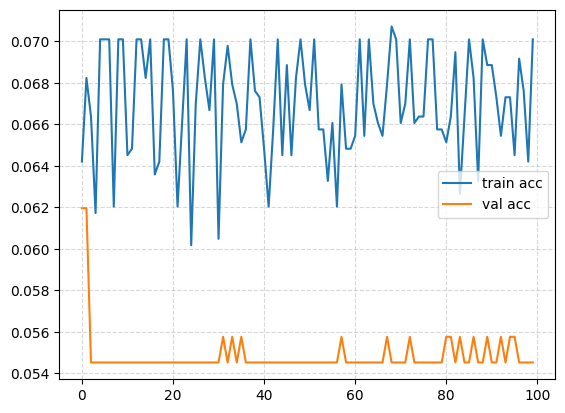

val acc => 6.20%


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)
model = Model.build_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(all_y)))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)
Visualization.learning_plot(history)
print(f"val acc => {np.max(history.history['val_accuracy'])*100:.2f}%")

In [4]:
Features = ['mav', 'var', 'zc', 'iemg', 'wl', 'wamp', 'mavs', 'rms', 'ssc', 'msq', 'v3', 'ld', 'dabs', 'mfl', 'mpr', 'mnf', 'psr', 'arc1', 'arc2', 'arc3', 'arc4', 'cc1', 'cc2', 'cc3', 'cca', 'dwtc1', 'dwtc2', 'dwtpc1', 'dwtpc2', 'dwtpc3']


Sub_acc = []
for feature_idx in range(num_features):
    X_feature = all_X[:, :, feature_idx]   # shape: (samples, num_channels, 1, 1)
    X_feature = X_feature.reshape(-1, num_channels, 1)

    X_train, X_test, y_train, y_test = train_test_split(X_feature, all_y, test_size=0.2, random_state=42)

    model = Model.build_model_1D(input_shape=X_feature.shape[1:], num_classes=len(np.unique(all_y)))

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=512, verbose=0)

    print(f"Feature {feature_idx} ({Features[feature_idx]}): "
        f"val acc => {np.max(history.history['val_accuracy'])*100:.2f}%")
    Sub_acc.append(np.max(history.history['val_accuracy'])*100)

print("\n")

ERROR! Session/line number was not unique in database. History logging moved to new session 5931
Feature 0 (mav): val acc => 51.30%
Feature 1 (var): val acc => 22.18%
Feature 2 (zc): val acc => 95.79%
Feature 3 (iemg): val acc => 95.04%
Feature 4 (wl): val acc => 97.27%
Feature 5 (wamp): val acc => 56.63%
Feature 6 (mavs): val acc => 6.82%
Feature 7 (rms): val acc => 42.01%
Feature 8 (ssc): val acc => 12.52%
Feature 9 (msq): val acc => 25.53%
Feature 10 (v3): val acc => 13.63%
Feature 11 (ld): val acc => 25.15%
Feature 12 (dabs): val acc => 33.21%
Feature 13 (mfl): val acc => 7.68%
Feature 14 (mpr): val acc => 33.95%
Feature 15 (mnf): val acc => 47.09%
Feature 16 (psr): val acc => 7.06%
Feature 17 (arc1): val acc => 31.23%
Feature 18 (arc2): val acc => 23.54%
Feature 19 (arc3): val acc => 18.96%
Feature 20 (arc4): val acc => 20.45%
Feature 21 (cc1): val acc => 5.70%
Feature 22 (cc2): val acc => 5.45%
Feature 23 (cc3): val acc => 8.67%
Feature 24 (cca): val acc => 8.67%
Feature 25 (dwtc